In [182]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py

from keras.models import load_model
from tensorflow.keras.optimizers import Adam 
import seaborn as sns

from tqdm import tqdm
import wfdb
import ast

In [3]:
lead_order = ["DI", "DII", "DIII", "AVL", "AVF", "AVR", "V1", "V2", "V3", "V4", "V5", "V6"]
df_attributes=pd.read_csv("attributes.csv")
path_data = "C:/Users/danih/OneDrive/Bureau/M2MAPI3/Machine_Learning/Projets/BIG_PROJECT"

df_goldStandard = pd.read_csv(f'{path_data}/data/data/annotations/gold_standard.csv')
df_goldStandard.rename(columns={"1dAVb":"Un_dAVb"},inplace=True)

df_card1= pd.read_csv(f'{path_data}/data/data/annotations/cardiologist1.csv')
df_card1.rename(columns={"1dAVb":"Und_AVb"},inplace=True)

df_card2= pd.read_csv(f'{path_data}/data/data/annotations/cardiologist2.csv')
df_card2.rename(columns={"1dAVb":"Und_AVb"},inplace=True)

df_dnn= pd.read_csv(f'{path_data}/data/data/annotations/dnn.csv')
df_dnn.rename(columns={"1dAVb":"Und_AVb"},inplace=True)


df_card_res= pd.read_csv(f'{path_data}/data/data/annotations/cardiology_residents.csv')
df_card_res.rename(columns={"1dAVb":"Und_AVb"},inplace=True)

df_emerg_res= pd.read_csv(f'{path_data}/data/data/annotations/emergency_residents.csv')
df_emerg_res.rename(columns={"1dAVb":"Un_dAVb"},inplace=True)

df_medical_students= pd.read_csv(f'{path_data}/data/data/annotations/medical_students.csv')
df_medical_students.rename(columns={"1dAVb":"Un_dAVb"},inplace=True)




df_dnn.drop('Unnamed: 0',axis=1,inplace=True)


# df=df_goldStandard.join(df_cardiologist1,lsuffix='_goldStandard', rsuffix='_card1').join(df_cardiologist2,
#     rsuffix='card_2').join(df_dnn,rsuffix='_dnn').join(df_cardiology_residents,rsuffix='_card_res').join(
#     df_emergency_residents,rsuffix='_emerg_res').join(df_medical_students,rsuffix='_med_stud').join(df_attributes)


df_goldStandard['nb_abnormality'] =  df_goldStandard.sum(axis=1)

# Visualisation des données

In [4]:
df_goldStandard.describe()

Un_dAVb        RBBB        LBBB          SB          AF          ST  \
count  827.000000  827.000000  827.000000  827.000000  827.000000  827.000000   
mean     0.033857    0.041112    0.036276    0.019347    0.015719    0.044740   
std      0.180971    0.198670    0.187088    0.137825    0.124463    0.206858   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

       nb_abnormality  
count      827.000000  
mean         0.191052  
std          0.428712  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          0.000000  
max          2.000000

<AxesSubplot:>

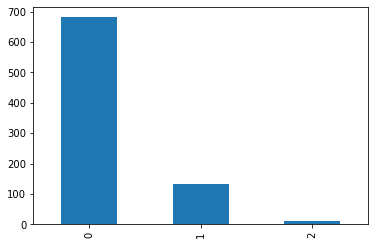

In [6]:
df_goldStandard['nb_abnormality'].value_counts().plot.bar()

<AxesSubplot:xlabel='age', ylabel='sex'>

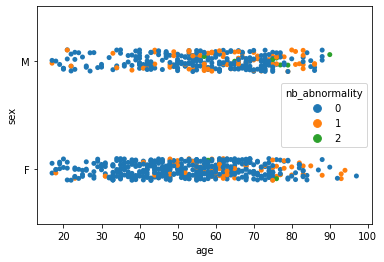

In [19]:
data = df_goldStandard.join(df_attributes)

sns.stripplot(x='age',y='sex', data = data, hue ='nb_abnormality')


<AxesSubplot:>

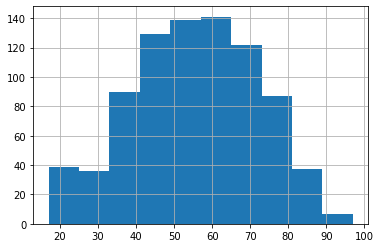

In [18]:
data['age'].hist()

In [20]:
data['sex'].replace(['M', 'F'], [0, 1], inplace=True)

In [21]:
data.groupby(['sex']).mean()

Un_dAVb      RBBB      LBBB        SB        AF        ST  \
sex                                                               
0    0.052960  0.059190  0.049844  0.037383  0.024922  0.046729   
1    0.021739  0.029644  0.027668  0.007905  0.009881  0.043478   

     nb_abnormality        age  
sex                             
0          0.271028  57.018692  
1          0.140316  53.624506

In [22]:
data.groupby(['nb_abnormality']).mean()

Un_dAVb      RBBB      LBBB        SB        AF        ST  \
nb_abnormality                                                               
0               0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1               0.149254  0.208955  0.186567  0.111940  0.082090  0.261194   
2               0.666667  0.500000  0.416667  0.083333  0.166667  0.166667   

                      age       sex  
nb_abnormality                       
0               53.217327  0.646109  
1               62.149254  0.455224  
2               72.333333  0.416667

<AxesSubplot:>

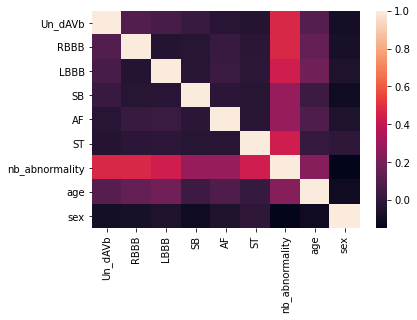

In [23]:
sns.heatmap(data.corr())

## Visualisation des ECG

In [85]:
with h5py.File(f"{path_data}/data/data/ecg_tracings.hdf5", "r") as f:
    x = np.array(f['tracings'])
print(x.shape)

(827, 4096, 12)


In [33]:
model = load_model(f"{path_data}/model/model/model.hdf5", compile=False)
model.compile(loss='binary_crossentropy', optimizer=Adam())

print(model.summary())

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
signal (InputLayer)             [(None, 4096, 12)]   0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 4096, 64)     12288       signal[0][0]                     
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 4096, 64)     256         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 4096, 64)     0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [36]:
import tensorflow as tf
from keras import backend as k


def find_last_conv(model):
    for layer in reversed(model.layers):
        if len(layer.output_shape) == 3:
            return layer.name


def grad_cam(model, time_serie, class_index, relative=True):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(find_last_conv(model)).output, model.output])
    with tf.GradientTape() as tape:
        inputs = tf.cast([time_serie], tf.float32)
        conv_outputs, predictions = grad_model(inputs)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    A = np.asarray(conv_outputs[0,:,:])
    dy = np.asarray(grads[0,:,:])
    a_k = dy.mean(axis=0)
    heat_map = np.sum(a_k*A, axis=1)
    heat_map = heat_map * (heat_map>0)
  
    if relative :
        heat_map /= heat_map.max()+1e-6
    return heat_map

In [39]:
from scipy.interpolate import interp1d

def plot_grad_cam_ecg(ts, check_y, selected_leads=True, relatives=True):
    hm = grad_cam(model, ts, check_y, relative=relatives)
    hm_interp = interp1d(np.linspace(0,10.24,16), hm, kind='slinear')
    if selected_leads:
        fig, axs = plt.subplots(1, 3,figsize=(40,5))
        for i,pos in enumerate([1,6,11]):
            ax = axs[i]
            ax.set_title(lead_order[pos],fontsize=10)
            ax.plot(np.linspace(0,10.24,4096),ts[:,pos],'k', linewidth=.5)
            t = ax.scatter(np.linspace(0,10.24,4096),ts[:,pos],linewidths=.1,c=hm_interp(np.linspace(0,10.24,4096)))
        fig.colorbar(t,ax=axs)
        plt.show()
    
    else :
        fig, axs = plt.subplots(4, 3,figsize=(20,16))
        for i in range(12):
            ax = axs[i//3, i%3]
            ax.set_title(lead_order[i],fontsize=10)
            ax.plot(np.linspace(0,10.24,4096),ts[:,pos],'k', linewidth=.5)
            t = ax.scatter(np.linspace(0,10.24,4096),ts[:,pos],linewidths=.1,c=hm_interp(np.linspace(0,10.24,4096)))
        fig.colorbar(t,ax=axs)
        plt.show()

Un_dAVb 0
RBBB 1
LBBB 2
SB 3
AF 4
ST 5


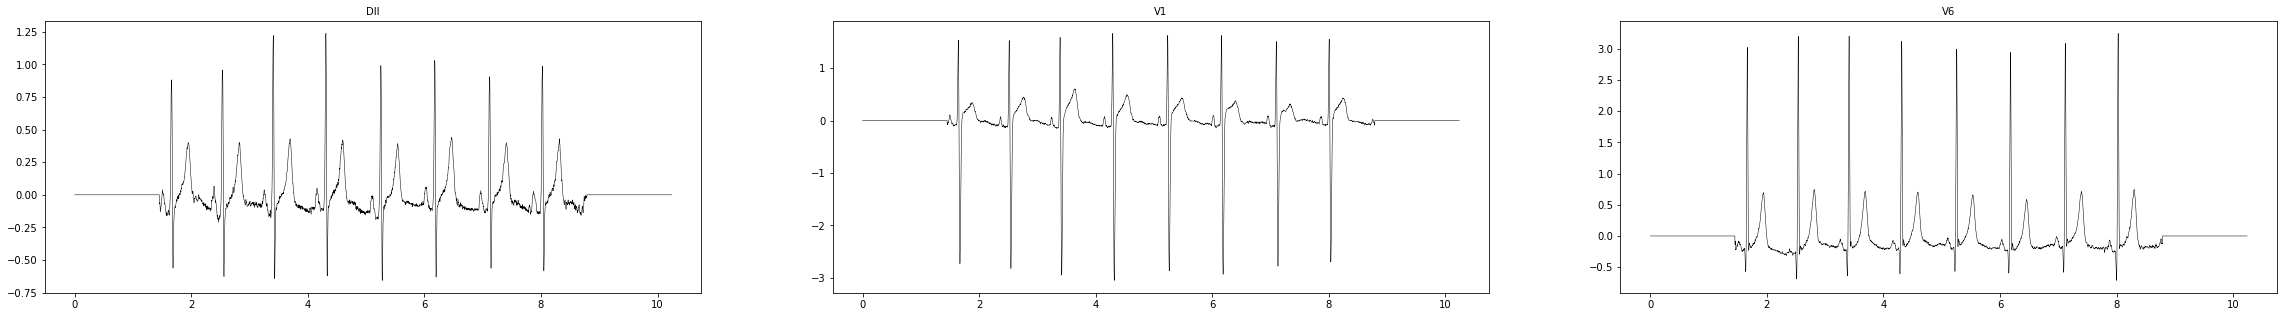

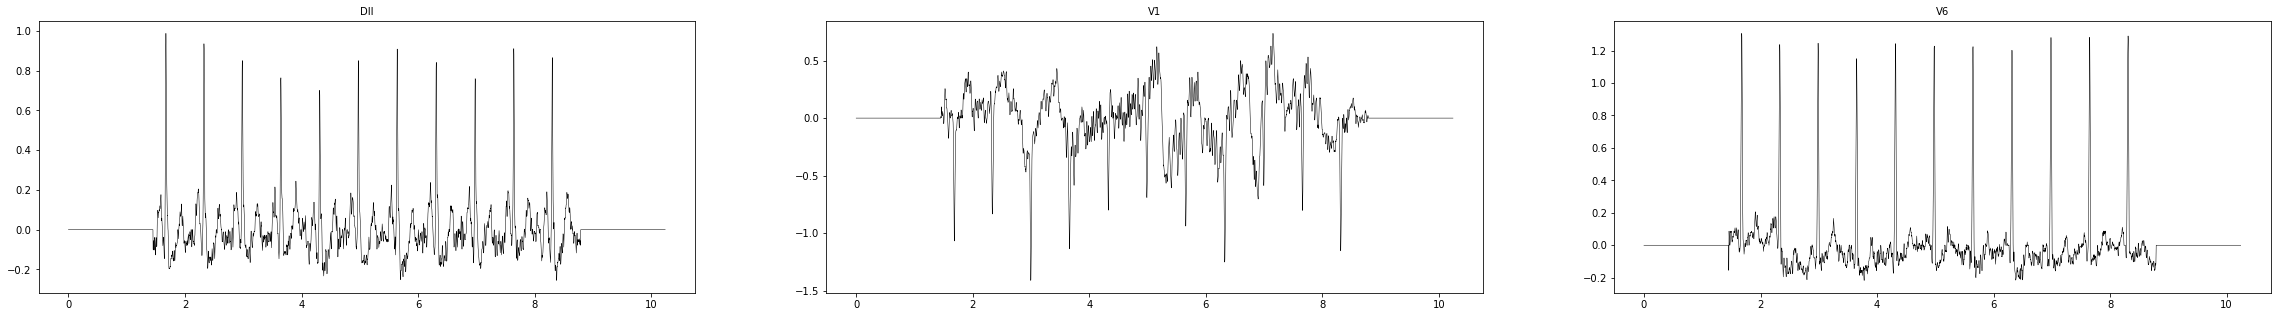

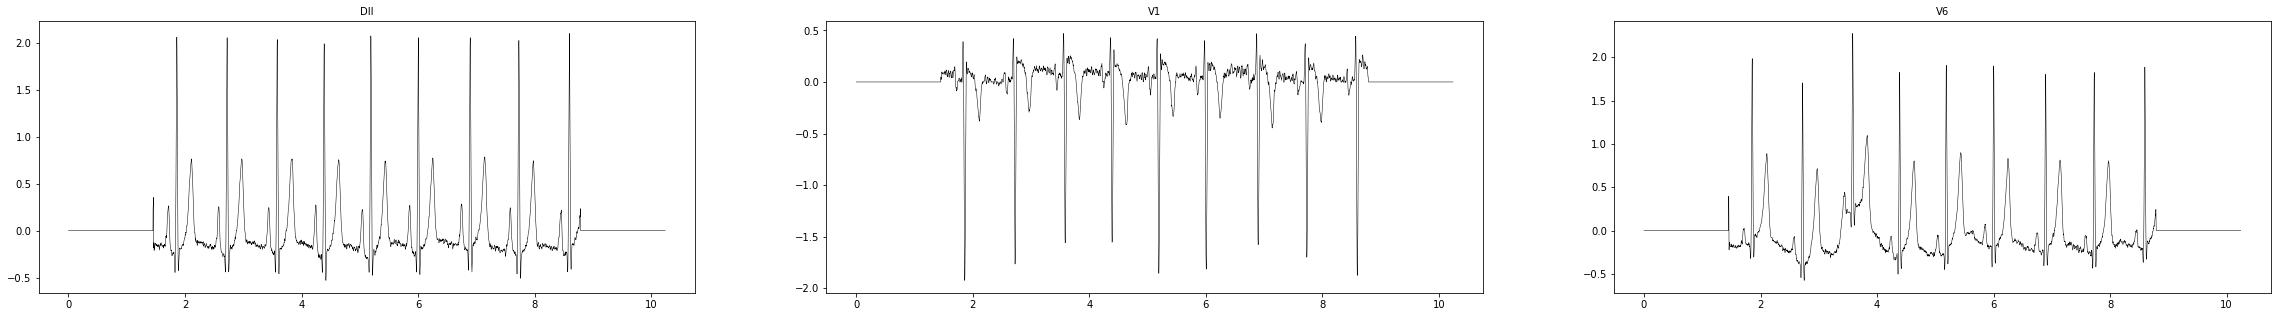

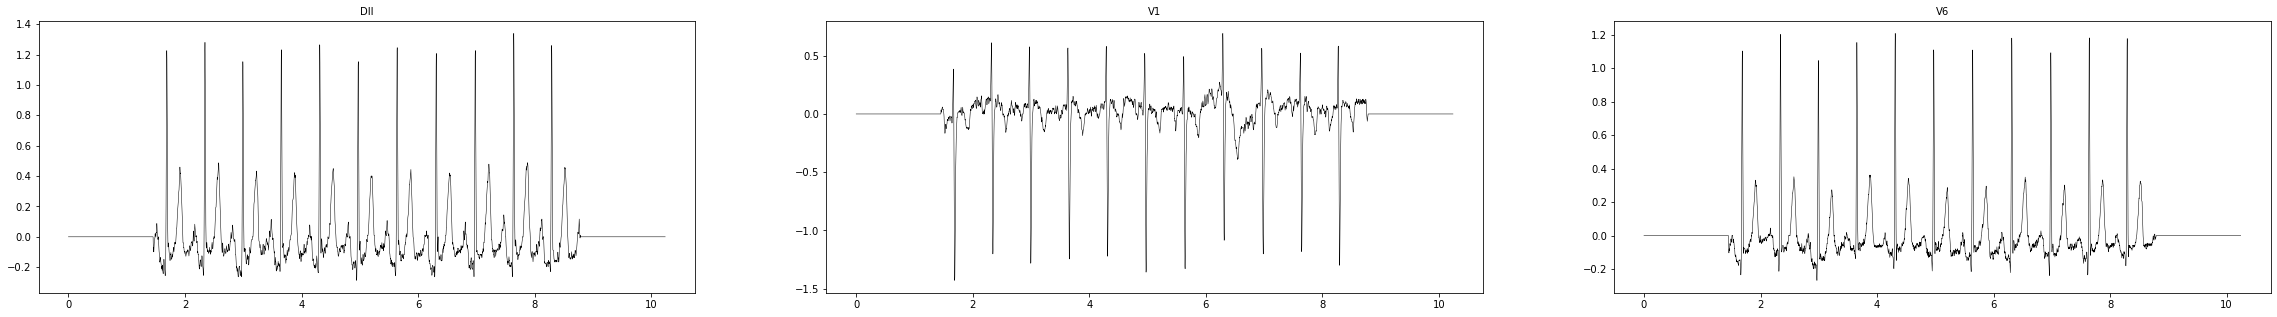

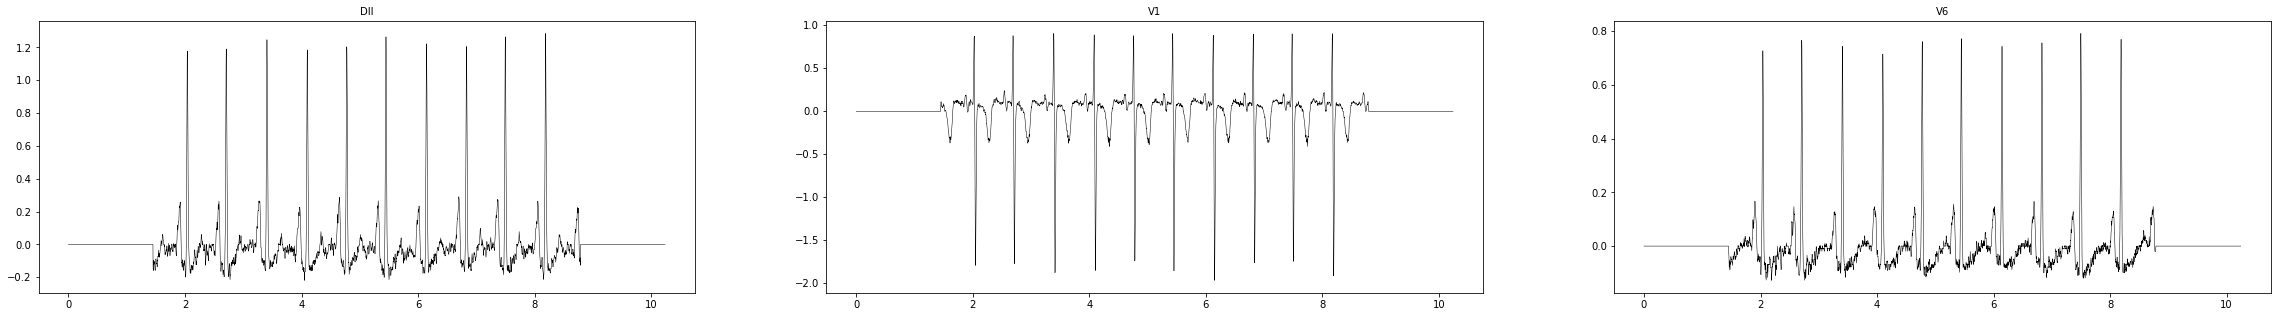



###########	 Un_dAVb	###########

Un_dAVb           1
RBBB              0
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 12, dtype: int64
[0.19 0.   0.   0.   0.   0.  ]


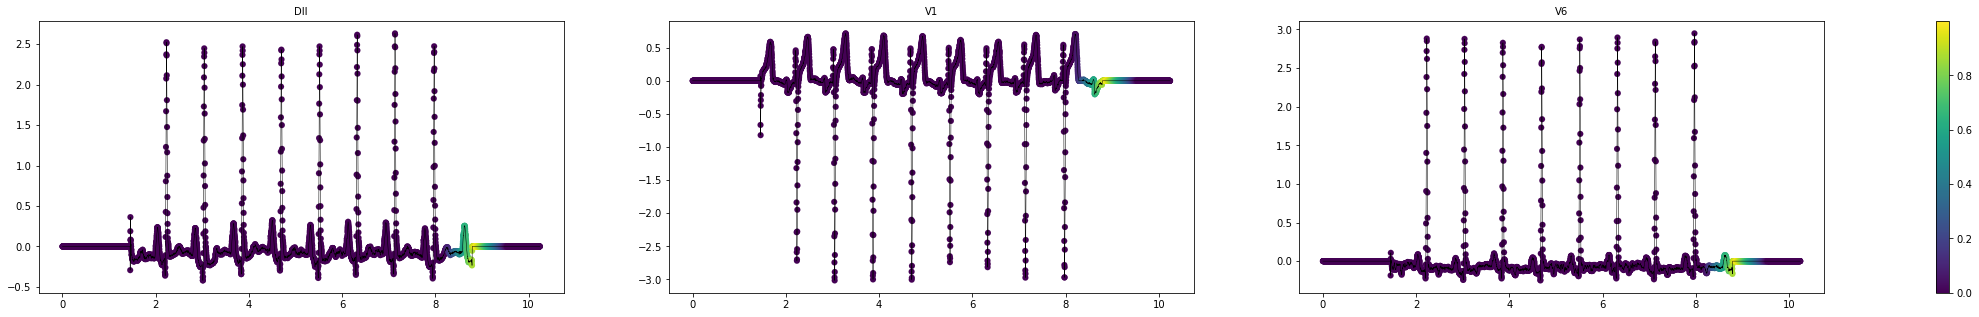

Un_dAVb           1
RBBB              0
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 32, dtype: int64
[0.16 0.   0.   0.   0.06 0.  ]


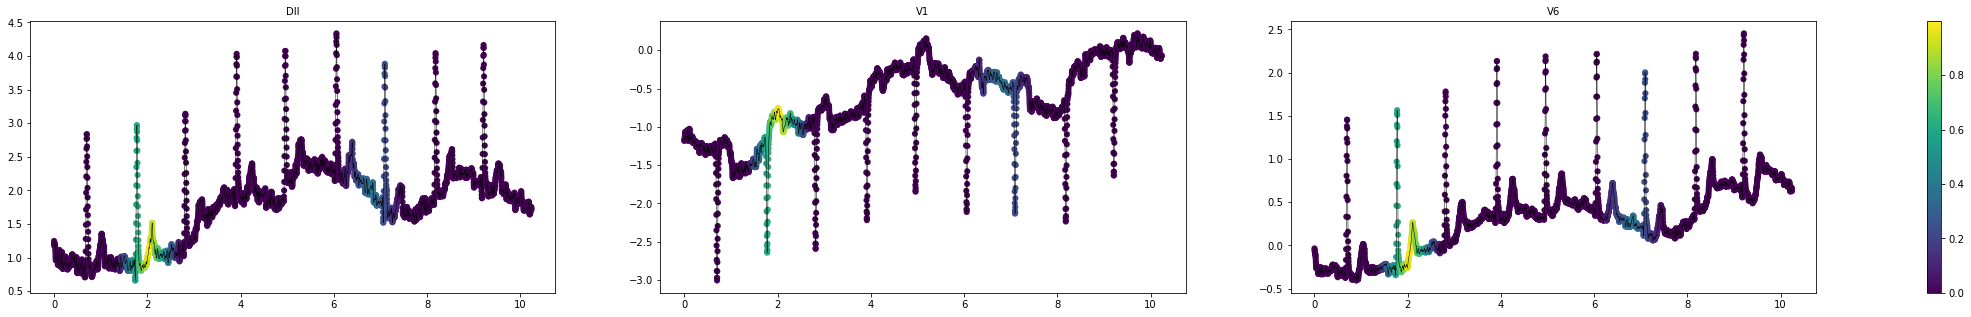

Un_dAVb           1
RBBB              0
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 57, dtype: int64
[0.06 0.   0.   0.   0.   0.  ]


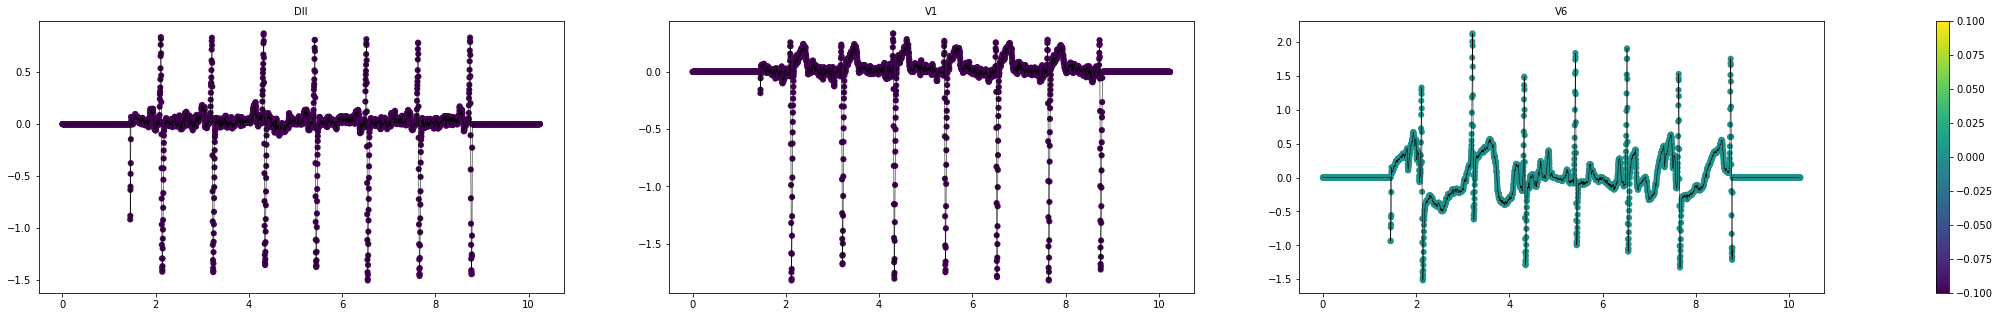



###########	 RBBB	###########

Un_dAVb           0
RBBB              1
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 106, dtype: int64
[0.   0.79 0.   0.   0.   0.  ]


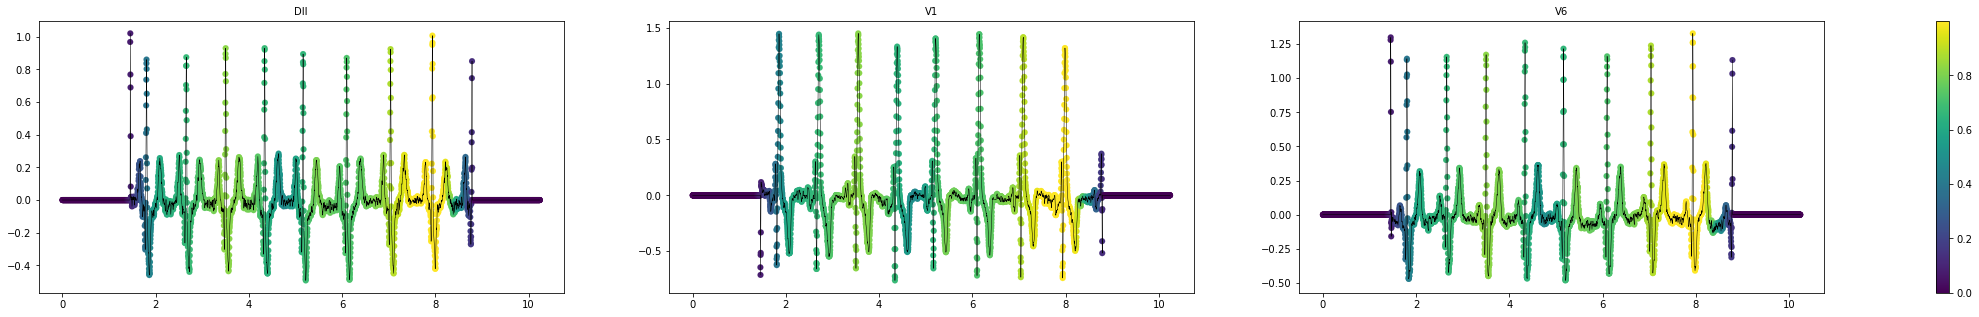

Un_dAVb           0
RBBB              1
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 241, dtype: int64
[0.   0.43 0.   0.   0.   0.  ]


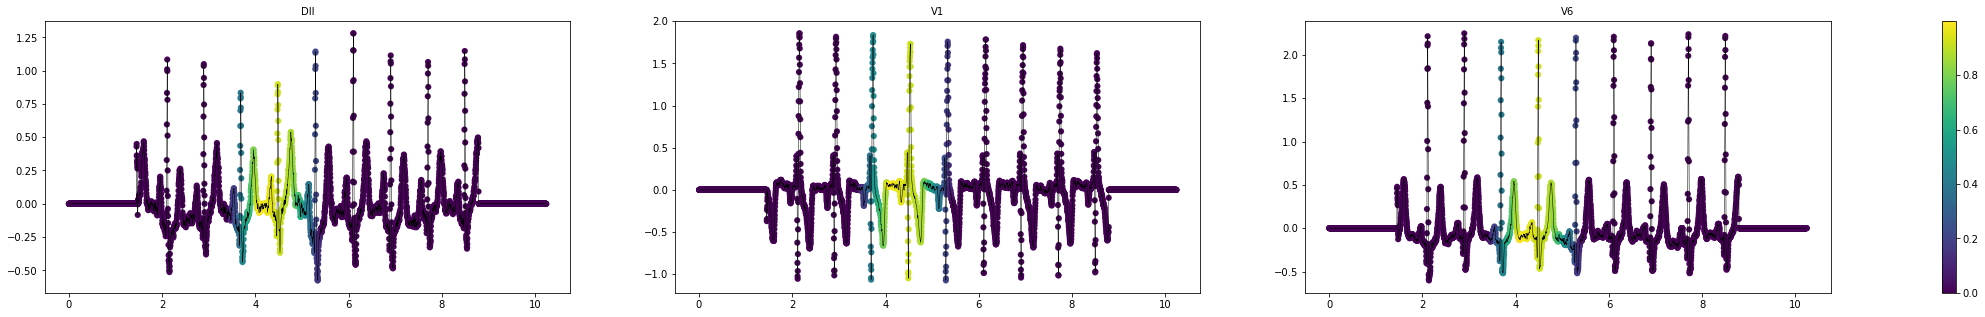

Un_dAVb           0
RBBB              1
LBBB              0
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 255, dtype: int64
[0.02 0.74 0.   0.   0.   0.  ]


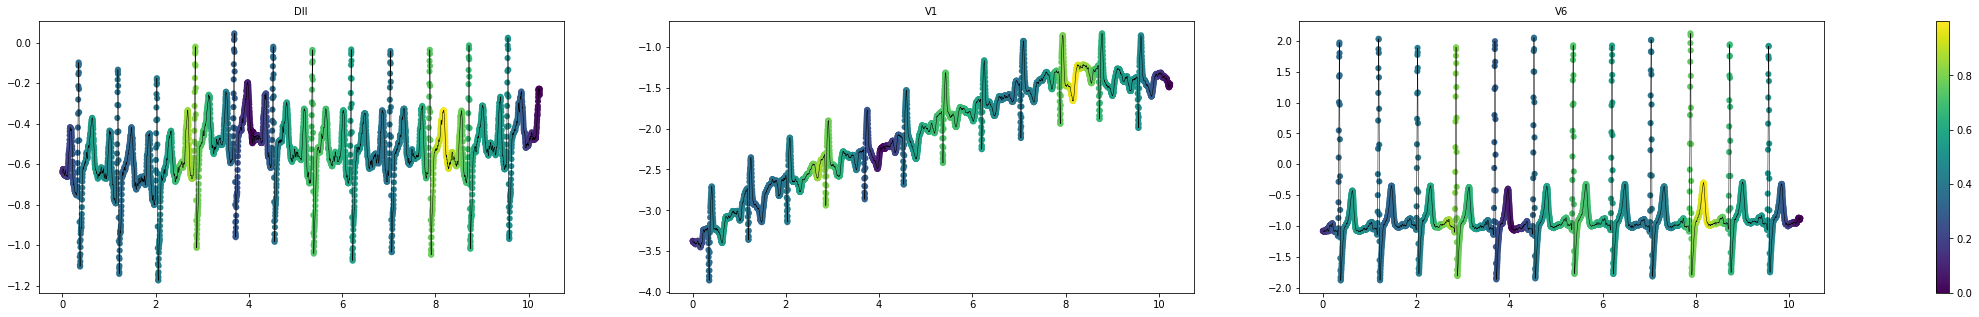



###########	 LBBB	###########

Un_dAVb           0
RBBB              0
LBBB              1
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 1, dtype: int64
[0.03 0.   0.32 0.   0.05 0.  ]


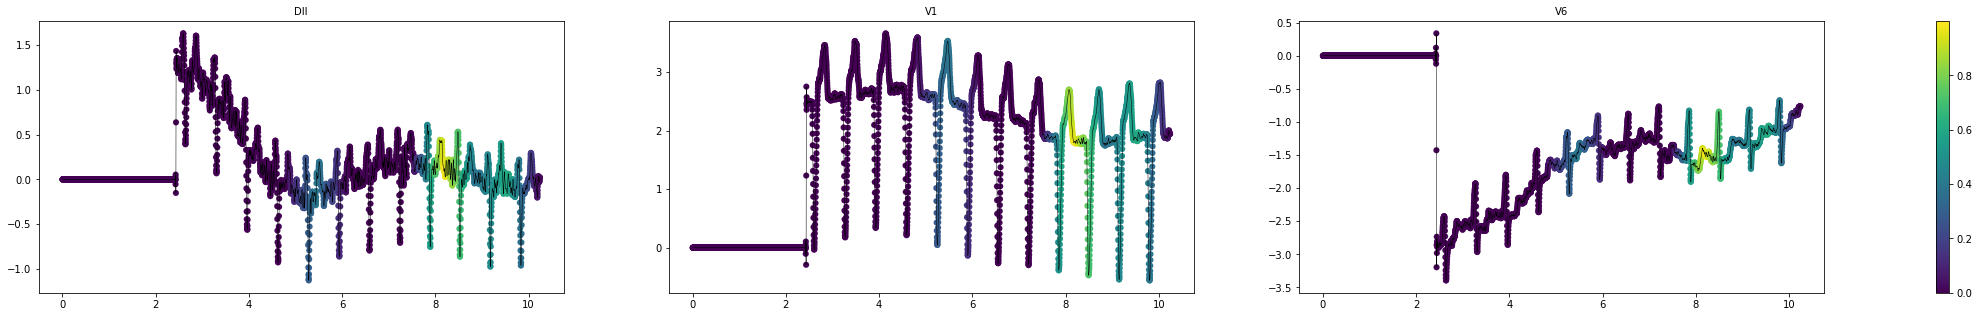

Un_dAVb           0
RBBB              0
LBBB              1
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 28, dtype: int64
[0.01 0.   0.84 0.   0.01 0.  ]


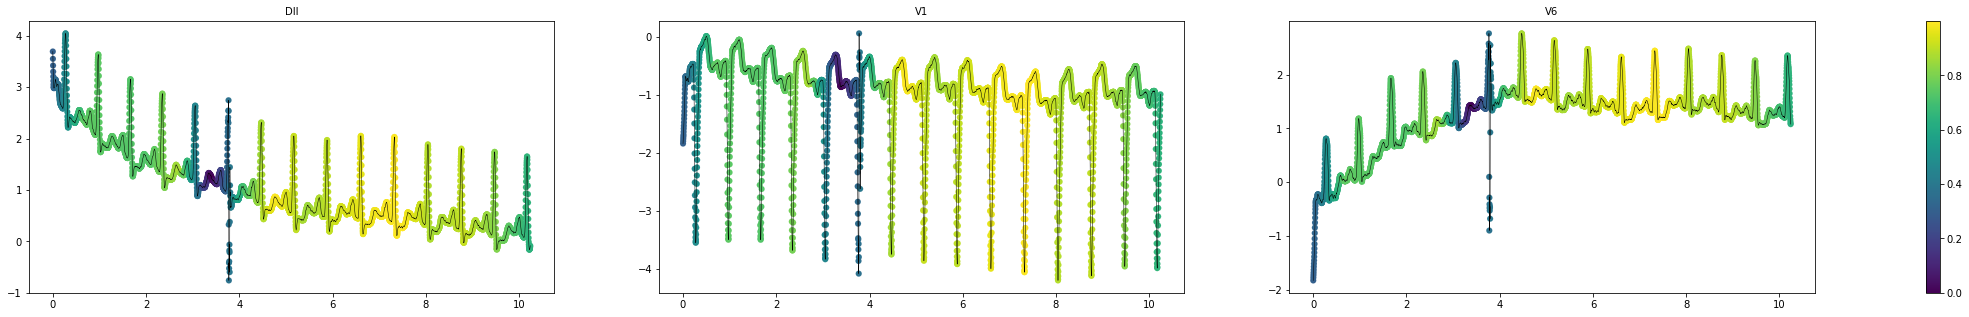

Un_dAVb           0
RBBB              0
LBBB              1
SB                0
AF                0
ST                0
nb_abnormality    1
Name: 58, dtype: int64
[0.   0.   0.52 0.   0.   0.  ]


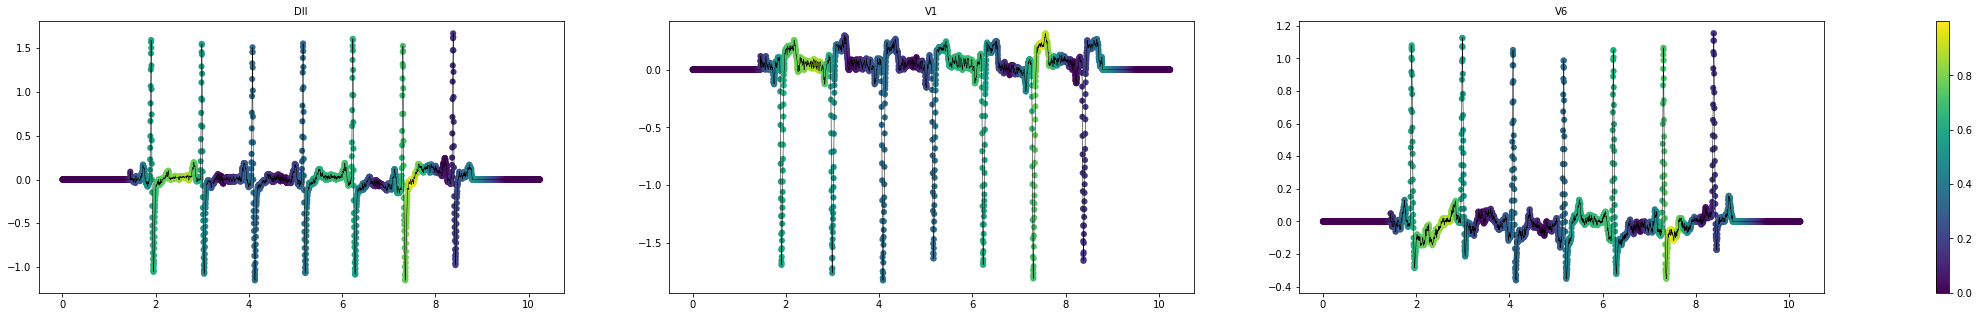



###########	 SB	###########

Un_dAVb           0
RBBB              0
LBBB              0
SB                1
AF                0
ST                0
nb_abnormality    1
Name: 40, dtype: int64
[0.   0.   0.   0.61 0.01 0.  ]


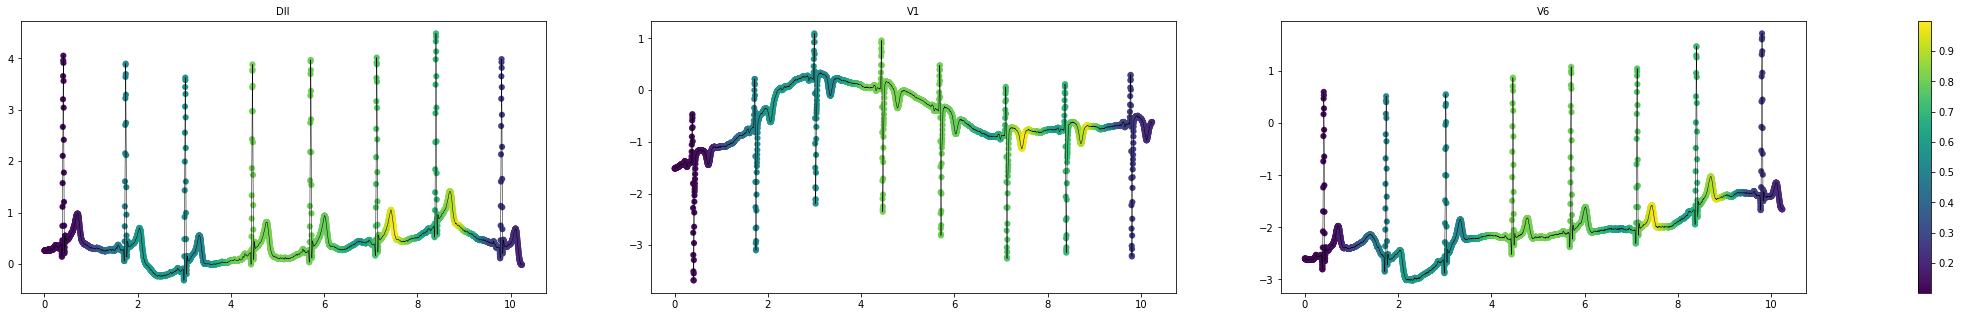

Un_dAVb           0
RBBB              0
LBBB              0
SB                1
AF                0
ST                0
nb_abnormality    1
Name: 75, dtype: int64
[0.01 0.01 0.   0.51 0.01 0.  ]


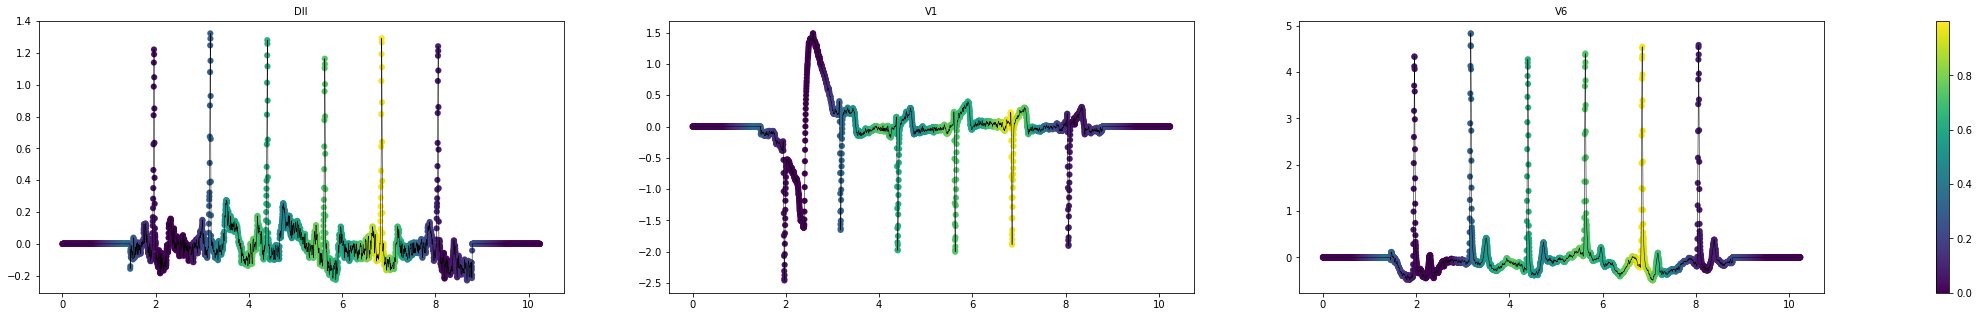

Un_dAVb           0
RBBB              0
LBBB              0
SB                1
AF                0
ST                0
nb_abnormality    1
Name: 98, dtype: int64
[0.   0.   0.   0.56 0.   0.  ]


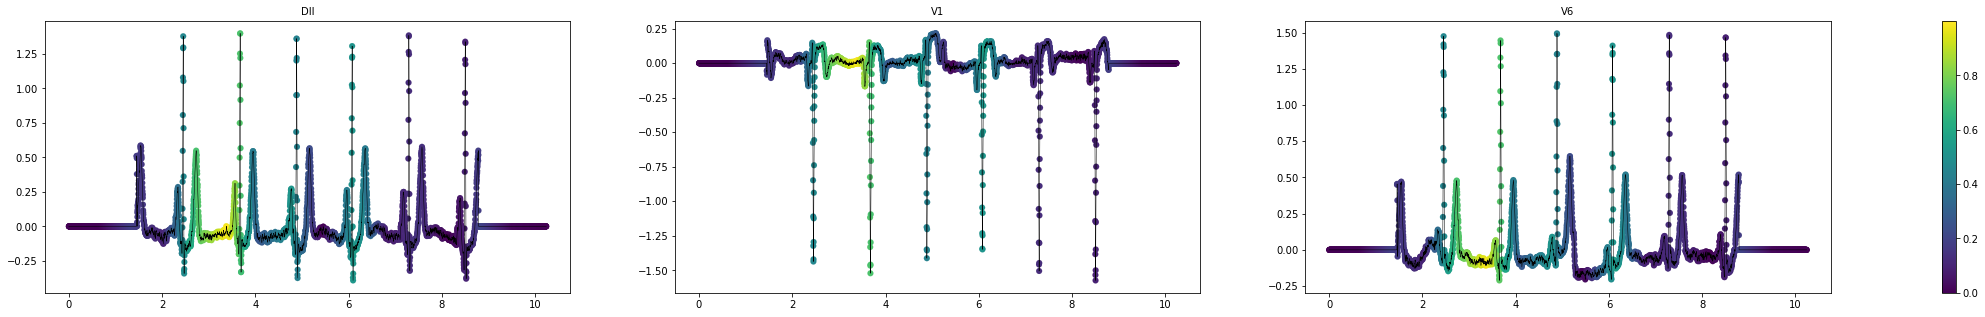



###########	 AF	###########

Un_dAVb           0
RBBB              0
LBBB              0
SB                0
AF                1
ST                0
nb_abnormality    1
Name: 120, dtype: int64
[0.   0.   0.   0.   0.94 0.  ]


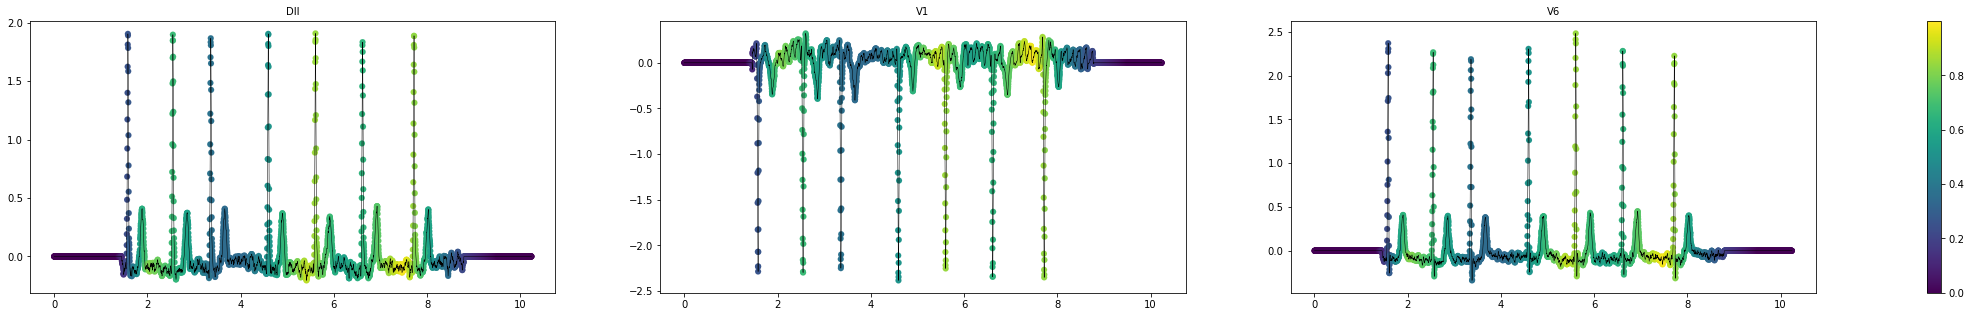

Un_dAVb           0
RBBB              0
LBBB              0
SB                0
AF                1
ST                0
nb_abnormality    1
Name: 170, dtype: int64
[0.04 0.   0.   0.   0.21 0.  ]


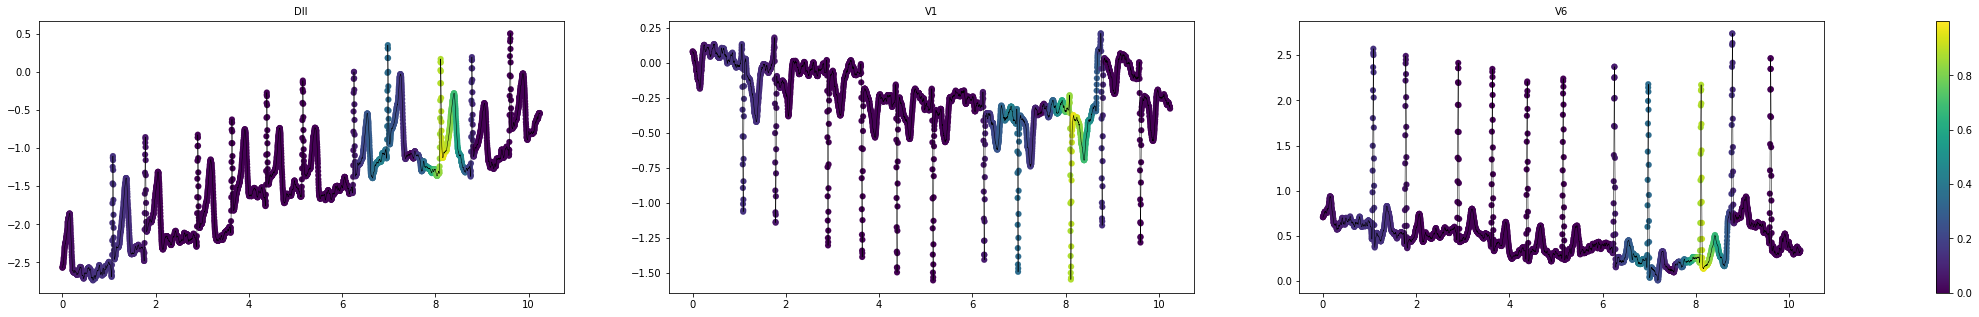

Un_dAVb           0
RBBB              0
LBBB              0
SB                0
AF                1
ST                0
nb_abnormality    1
Name: 259, dtype: int64
[0.   0.   0.   0.   0.93 0.  ]


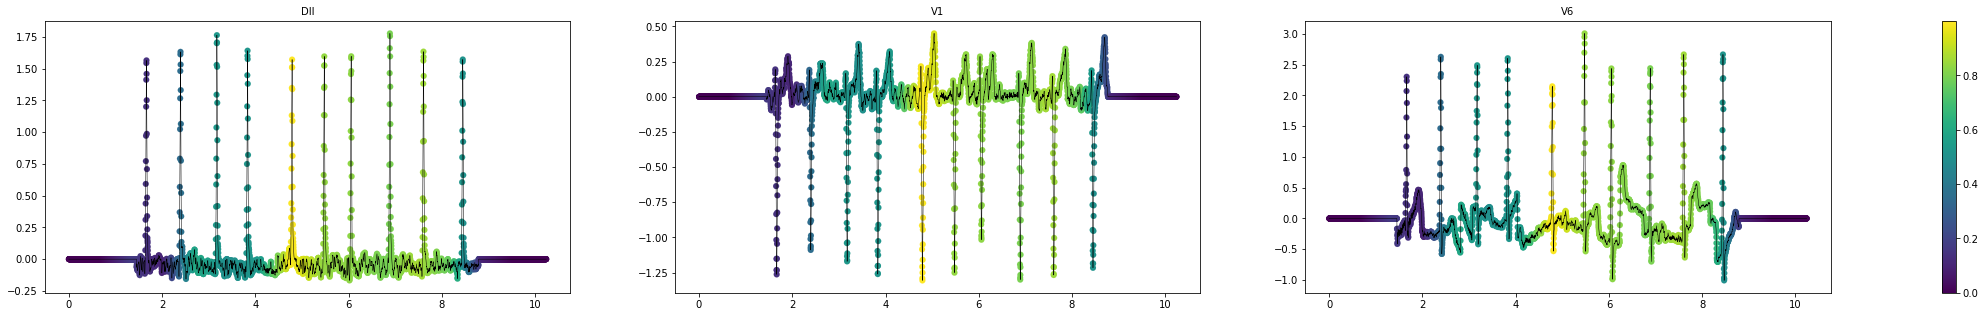



###########	 ST	###########

Un_dAVb           0
RBBB              0
LBBB              0
SB                0
AF                0
ST                1
nb_abnormality    1
Name: 23, dtype: int64
[0.   0.   0.   0.   0.05 0.38]


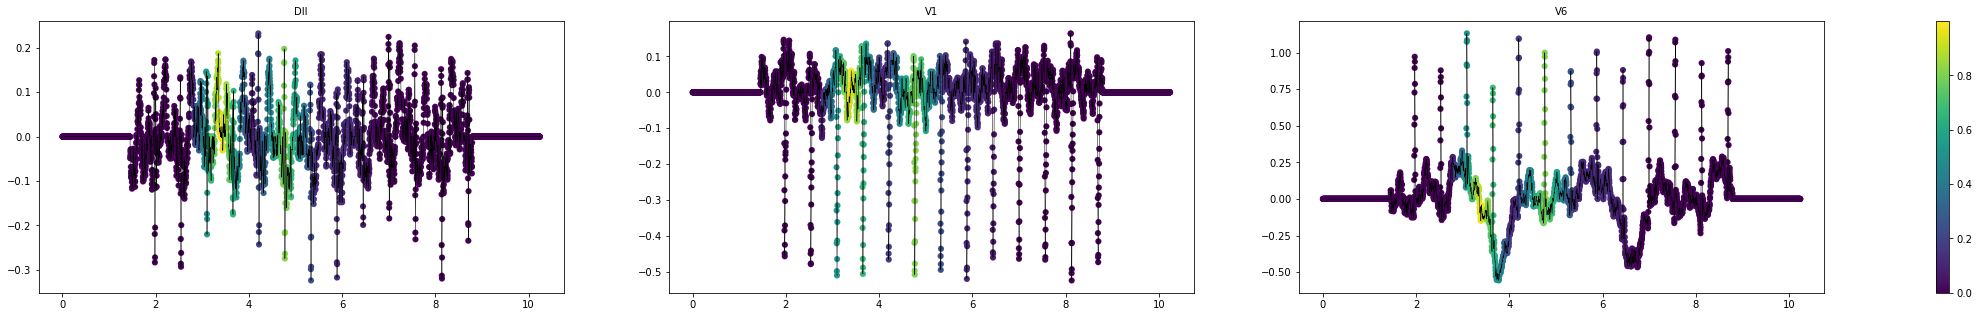

Un_dAVb           0
RBBB              0
LBBB              0
SB                0
AF                0
ST                1
nb_abnormality    1
Name: 33, dtype: int64
[0.   0.   0.   0.   0.   0.61]


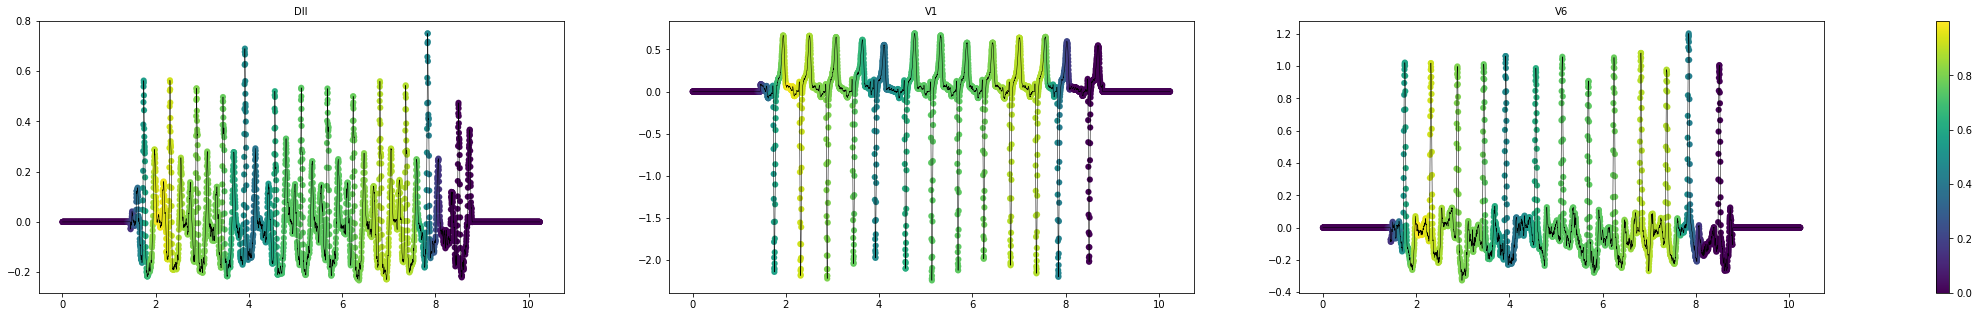

Un_dAVb           0
RBBB              0
LBBB              0
SB                0
AF                0
ST                1
nb_abnormality    1
Name: 69, dtype: int64
[0.   0.   0.   0.   0.   0.61]


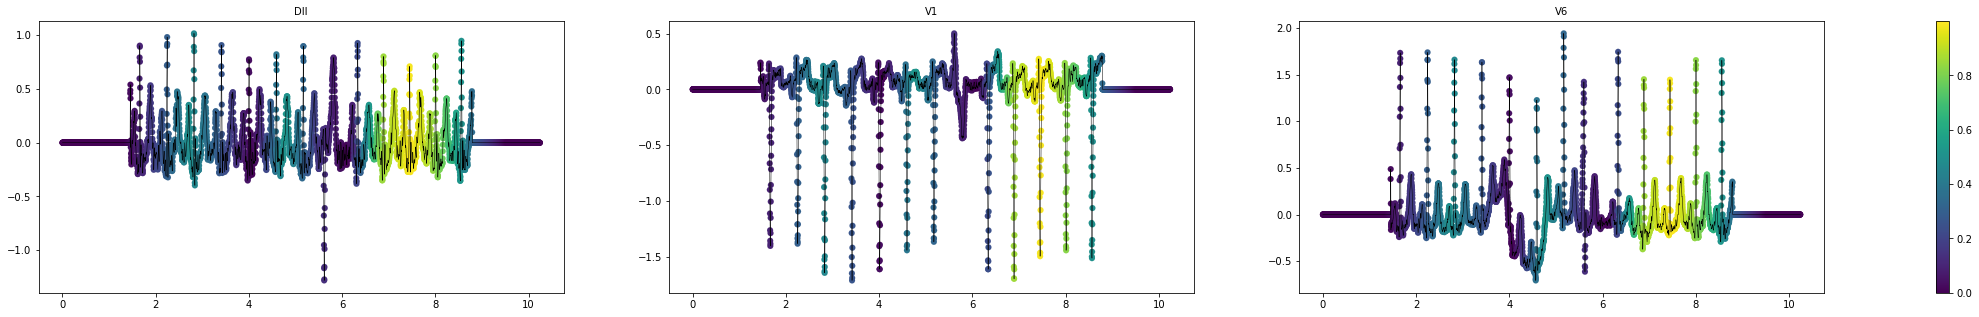

In [41]:
for idx_abn, abnormality in enumerate(df_goldStandard.columns[:-1]):
    print(abnormality,idx_abn)

# visualisation a refaire en mieux
for idx_safe in df_goldStandard[df_goldStandard.nb_abnormality==0].index[:5]:
    fig, axs = plt.subplots(1, 3,figsize=(40,5))
    for i,pos in enumerate([1,6,11]):
        ax = axs[i]
        ax.set_title(lead_order[pos],fontsize=10)
        ax.plot(np.linspace(0,10.24,4096),x[idx_safe,:,pos],'k', linewidth=.5)
    plt.show()

for idx_abn, abnormality in enumerate(df_goldStandard.columns[:-1]):
    index_abnormality = df_goldStandard[(df_goldStandard[abnormality]==1)&(df_goldStandard.nb_abnormality==1)].index
    print(f'\n\n###########\t {abnormality}\t###########\n')
    preds = model.predict(x[index_abnormality[:3]])
    for i, pos in enumerate(index_abnormality[:3]):
        np.set_printoptions(precision=2,suppress=True)
        print(df_goldStandard.iloc[pos])
        print(preds[i])
        plot_grad_cam_ecg(x[pos],check_y=idx_abn)

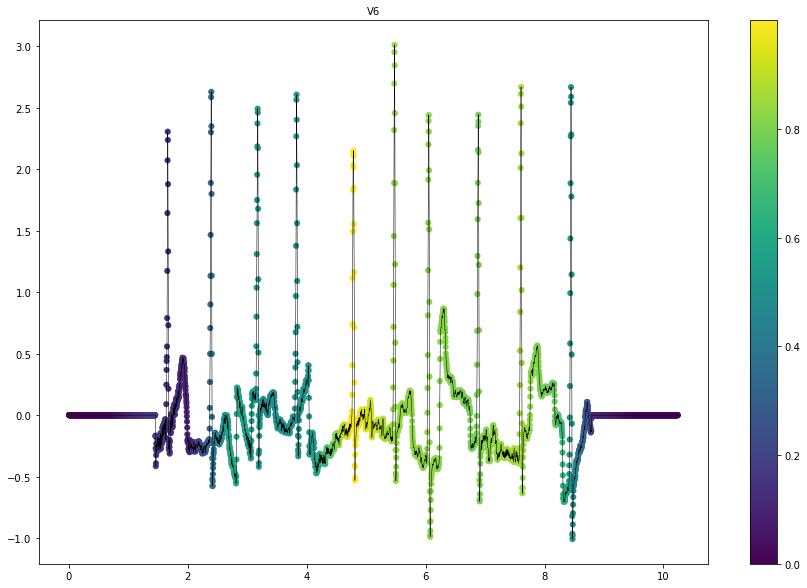

In [42]:
# visualiser une ECG
pos=259
ts = x[pos]
hm = grad_cam(model, ts, 4)
hm_interp = interp1d(np.linspace(0,10.24,16), hm, kind='slinear')

fig, ax= plt.subplots(1,1,figsize=(15,10))
ax.set_title('V6',fontsize=10)
ax.plot(np.linspace(0,10.24,4096),ts[:,11],'k', linewidth=.5)
t = ax.scatter(np.linspace(0,10.24,4096),ts[:,11],linewidths=.1,c=hm_interp(np.linspace(0,10.24,4096)))
fig.colorbar(t,ax=ax)
plt.savefig('V6.png', dpi=600)

## Evaluation du classifieur

In [50]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [48]:
y_pred = model.predict(x,verbose = 1)
y_pred = np.round(y_pred,4)

26/26 [==============================] - 16s 620ms/step


In [49]:
ind = np.linspace(0,826,827)
df_pred = pd.DataFrame(y_pred, index = ind,columns=['Proba_1dAVb','Proba_RBBB','Proba_LBBB','Proba_SB','Proba_AF','Proba_ST'])

display(df_pred)    #prédictions du réseau de neurones sur le modèle pré-entrainé

Proba_1dAVb  Proba_RBBB  Proba_LBBB  Proba_SB  Proba_AF  Proba_ST
0.0         0.0000      0.0000      0.0000       0.0    0.0000    0.0000
1.0         0.0289      0.0020      0.3178       0.0    0.0483    0.0003
2.0         0.0003      0.0000      0.0000       0.0    0.0093    0.0000
3.0         0.0000      0.0000      0.0000       0.0    0.0000    0.0000
4.0         0.0005      0.0000      0.0000       0.0    0.0002    0.0000
...            ...         ...         ...       ...       ...       ...
822.0       0.0000      0.0000      0.0000       0.0    0.0000    0.0000
823.0       0.0004      0.0000      0.0001       0.0    0.0008    0.0000
824.0       0.0000      0.0000      0.0000       0.0    0.0000    0.0000
825.0       0.0000      0.0000      0.0000       0.0    0.0000    0.0000
826.0       0.1733      0.0025      0.0001       0.0    0.0021    0.0001

[827 rows x 6 columns]

Le réseau de neurones `model.hdf5`donne des probabilités d'avoir une anomalie, ces probabilités sont ensuite transformées en 0 ou 1 dans `df_dnn`, le seuil utilisé est le seuil qui maximise le F1-score. On peut ensuite évaluer la performance de ce modèle pour chaque anomalie.


In [57]:
df_dnn1 = df_dnn['Und_AVb']
df_dnn2 = df_dnn['RBBB']
df_dnn3 = df_dnn['LBBB']
df_dnn4 = df_dnn['SB']
df_dnn5 = df_dnn['AF']
df_dnn6 = df_dnn['ST']

gs1 = df_goldStandard['Un_dAVb']
gs2 = df_goldStandard['RBBB']
gs3 = df_goldStandard['LBBB']
gs4 = df_goldStandard['SB']
gs5 = df_goldStandard['AF']
gs6 = df_goldStandard['ST']

### 1st degree AV block (1dAVb)

In [67]:
c1 = confusion_matrix(df_dnn1,gs1)
print(c1)
f1 = f1_score(df_dnn1,gs1)
p1 = (c1[0][1] + c1[1][0]) / 827 * 100
print("Pourcentage d'erreur du dnn sur la premiere anomalie", p1)
print("f1-score du dnn sur la premiere anomalie :",f1)

[[795   2]
 [  4  26]]
Pourcentage d'erreur du dnn sur la premiere anomalie 0.7255139056831923
f1-score du dnn sur la premiere anomalie : 0.896551724137931


### right bundle branch block (RBBB)

In [68]:
c2 = confusion_matrix(df_dnn2,gs2)
print(c2)
f2 = f1_score(df_dnn2,gs2)
p2 = (c2[0][1] + c2[1][0]) / 827 * 100
print("Pourcentage d'erreur du dnn sur la deuxieme anomalie", p2)
print("f1-score du dnn sur la deuxieme anomalie :",f2)

[[789   0]
 [  4  34]]
Pourcentage d'erreur du dnn sur la deuxieme anomalie 0.48367593712212814
f1-score du dnn sur la deuxieme anomalie : 0.9444444444444444


### left bundle branch block (LBBB)

In [70]:
c3 = confusion_matrix(df_dnn3,gs3)
print(c3)
f3 = f1_score(df_dnn3,gs3)
p3 = (c3[0][1] + c3[1][0]) / 827 * 100
print("Pourcentage d'erreur du dnn sur la troisieme anomalie", p3)
print("f1-score du dnn sur la deuxieme troisieme :",f3)

[[797   0]
 [  0  30]]
Pourcentage d'erreur du dnn sur la troisieme anomalie 0.0
f1-score du dnn sur la deuxieme troisieme : 1.0


### sinus bradycardia (SB)

In [71]:
c4 = confusion_matrix(df_dnn4,gs4)
print(c4)
f4 = f1_score(df_dnn4,gs4)
p4 = (c4[0][1] + c4[1][0]) / 827 * 100
print("Pourcentage d'erreur du dnn sur la quatrieme anomalie", p4)
print("f1-score du dnn sur la quatrieme anomalie :",f4)

[[808   1]
 [  3  15]]
Pourcentage d'erreur du dnn sur la quatrieme anomalie 0.48367593712212814
f1-score du dnn sur la quatrieme anomalie : 0.8823529411764706


### atrial fibrillation (AF) 

In [73]:
c5 = confusion_matrix(df_dnn5,gs5)
print(c5)
f5 = f1_score(df_dnn5,gs5)
p5 = (c5[0][1] + c5[1][0]) / 827 * 100
print("Pourcentage d'erreur du dnn sur la cinquieme anomalie", p5)
print("f1-score du dnn sur la cinquieme anomalie :",f5)

[[814   3]
 [  0  10]]
Pourcentage d'erreur du dnn sur la cinquieme anomalie 0.36275695284159615
f1-score du dnn sur la cinquieme anomalie : 0.8695652173913044


### sinus tachycardia (ST)

In [75]:
c6 = confusion_matrix(df_dnn6,gs6)
print(c6)
f6 = f1_score(df_dnn6,gs6)
p6 = (c6[0][1] + c6[1][0]) / 827 * 100
print("Pourcentage d'erreur du dnn sur la sixieme anomalie", p6)
print("f1-score du dnn sur la sixieme anomalie :",f6)

[[788   1]
 [  2  36]]
Pourcentage d'erreur du dnn sur la sixieme anomalie 0.36275695284159615
f1-score du dnn sur la sixieme anomalie : 0.9599999999999999


## Comparaison avec un SVC

In [88]:
dx, dy, dz = x.shape                     #On redimensionne les données d'entrainement X

X = x.reshape(dx, dy * dz)

X = pd.DataFrame(X)
X.head()

0      1      2      3      4      5      6      7      8      9      ...  \
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
1    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
2    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
3    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   
4    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  ...   

      49142     49143     49144     49145     49146     49147    49148  \
0  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
1  0.407469 -0.397223  0.211611  0.178307  1.942285  2.809755  1.25819   
2  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
3  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   
4  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.00000   

      49149     49150     49151  
0  0.000000  0.000000  0.000000  
1  1.202997  1.659529 -0.759827  
2  0.000000  0.000000  0.000000  
3  0.000000  0.000000  0.000000  
4  0.000000  0.000000  0.000000  

[5 rows x 49152 columns]

### 1st degree AV block (1dAVb)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X,gs1, train_size = 0.8)

In [89]:
from sklearn.preprocessing import StandardScaler  
# On normalise les données 
scaler = StandardScaler()  
scaler.fit(X_train)  
Xr_train = scaler.transform(X_train)  
# Meme transformation sur le test
Xr_test = scaler.transform(X_test)

In [95]:
svc = SVC()
svc.fit(Xr_train,y_train)

SVC()

In [96]:
y_svc_pred = svc.predict(Xr_test)

In [97]:
print('F1 score du linearSVC=', f1_score(y_test,y_svc_pred))
confusion_matrix(y_test,y_svc_pred)

F1 score du linearSVC= 0.0


array([[162,   0],
       [  4,   0]], dtype=int64)

In [108]:
X_train, X_test, y_train, y_test = train_test_split(X,gs2, train_size = 0.8)

In [122]:
svc = SVC()
svc.class_weight = 'balanced'
svc.fit(X_train,y_train)

SVC(class_weight='balanced')

In [123]:
y_svc_pred = svc.predict(X_test)

In [124]:
print('F1 score du linearSVC=', f1_score(y_test,y_svc_pred))
confusion_matrix(y_test,y_svc_pred)

F1 score du linearSVC= 0.0


array([[158,   0],
       [  8,   0]], dtype=int64)

Sur le jeu de données test, le SVC a tout prédit en 0, par conséquent il est très mauvais dans le cas présent

## Tentative d'amélioration du dnn

On peut tenter d'améliorer les résultats du dnn en prenant en compte les probabilités calculées par le dnn et en y ajoutant les informations de l'âge et du sexe du patient.

In [126]:
df = df_pred.join(df_attributes).join(df_goldStandard)



In [135]:
df['sex'].replace(['M', 'F'], [0, 1], inplace=True)

In [127]:
threshold = 53 #moyenne en âge 

def category_ages(age):
    if age <= threshold:
        return 0
    else :
        return 1

df['sup53'] = df['age'].map(category_ages)

In [175]:
def dnn_and_svc(abnormality):
    features = ['Proba_1dAVb', 'Proba_RBBB', 'Proba_LBBB', 'Proba_SB', 'Proba_AF',
       'Proba_ST', 'sex', 'sup53']
    X = df[features]
    y= df[abnormality]
    print("Pourcentage de patients ayant l'anomalie ", np.sum(y)/len(y) * 100)
    X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.8)
    clf = SVC()

    clf.fit(X_train,y_train)

    y_pred = clf.predict(X_test)
    C = confusion_matrix(y_test,y_pred)
    print(C)
    print('F1 score du SVC=', f1_score(y_test,y_pred))
    print("Pourcentage d'erreur : ",(C[0][1]+C[1][0]) * 100/len(y_test))

In [176]:
dnn_and_svc('Un_dAVb')

Pourcentage de patients ayant l'anomalie  3.3857315598548974
[[163   0]
 [  3   0]]
F1 score du SVC= 0.0
Pourcentage d'erreur :  1.8072289156626506


In [177]:
dnn_and_svc('RBBB')

Pourcentage de patients ayant l'anomalie  4.111245465538089
[[159   0]
 [  1   6]]
F1 score du SVC= 0.923076923076923
Pourcentage d'erreur :  0.6024096385542169


In [178]:
dnn_and_svc('LBBB')

Pourcentage de patients ayant l'anomalie  3.6275695284159615
[[157   0]
 [  1   8]]
F1 score du SVC= 0.9411764705882353
Pourcentage d'erreur :  0.6024096385542169


In [179]:
dnn_and_svc('SB')

Pourcentage de patients ayant l'anomalie  1.9347037484885126
[[160   1]
 [  2   3]]
F1 score du SVC= 0.6666666666666665
Pourcentage d'erreur :  1.8072289156626506


In [180]:
dnn_and_svc('AF')

Pourcentage de patients ayant l'anomalie  1.5719467956469164
[[163   0]
 [  0   3]]
F1 score du SVC= 1.0
Pourcentage d'erreur :  0.0


In [181]:
dnn_and_svc('ST')

Pourcentage de patients ayant l'anomalie  4.474002418379685
[[160   1]
 [  1   4]]
F1 score du SVC= 0.8000000000000002
Pourcentage d'erreur :  1.2048192771084338


Les résultats sont un peu moins bons que les résultats du dnn avec maximisation du f1-score

### b. Get the data to prepare the training phase

In [183]:
def load_raw_data(df, sampling_rate, path):
    data = []
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        i=0
        for f in tqdm(df.filename_hr):
            data.append(wfdb.rdsamp(path+f))
            i+=1

    data = np.array([signal for signal, meta in data])
    return data

path = 'path/to/PTBXL'  #SET YOUR DIRECTORY HERE!!!
path = "C:/Users/danih/OneDrive/Bureau/M2MAPI3/Machine_Learning/Projets/BIG_PROJECT/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1/"
sampling_rate=500

# load and convert annotation data
Y = pd.read_csv(path + 'ptbxl_database.csv', index_col='ecg_id')

Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))


# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path+'scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

# Split data into train and test
test_fold = 10
# Train
X_train = X[np.where(Y.strat_fold != test_fold)]
y_train = Y[(Y.strat_fold != test_fold)].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass

100%|████████████████████████████████████████████████████████████████████████████| 21837/21837 [07:56<00:00, 45.78it/s]


MemoryError: Unable to allocate 9.76 GiB for an array with shape (21837, 5000, 12) and data type float64

In [184]:
signal

NameError: name 'signal' is not defined

In [ ]:
def delete_unk_ecg(x,y):
    y = list(y)
    x_processed,y_processed = [],[]
    for index,dis in enumerate(y):
        if dis != []:
            x_processed.append(x[index])
            y_processed.append(y[index])
    return x_processed,y_processed


X_train,y_train = delete_unk_ecg(X_train,y_train)
X_test,y_test = delete_unk_ecg(X_test,y_test)
            
y_train = np.array(y_train,dtype=object)
y_test = np.array(y_test,dtype=object)
X_train = np.array(X_train)
X_test = np.array(X_test)


In [ ]:
print(y_train.shape)
print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

###    c. Convert the y_train into a usable format  
    

In [ ]:
#Define the diseases
diseases = ["NORM","MI","HYP","CD","STTC"]

#Create a RIBEIRO format training data
def Ribeiro_convert(y_train):
    
    y_train = list(y_train)

    y_train_ = [[0,0,0,0] for i in list(y_train)]
    for index, info in enumerate(y_train):

        for disease in info:

            if disease != 'NORM':
                y_train_[index][diseases.index(disease)-1] = 1

    y_train_ = np.array(y_train_)
    return y_train_

y_train = Ribeiro_convert(y_train)
y_test = Ribeiro_convert(y_test)

print(y_train.shape)
print(y_test.shape)


##Reformat the ECG aquisition, 4048 samples needed.

### d. Rescale the data
    Ribeiro is adaptated to 400Hz/10sec : 4096 samples, on this dataset the ECG are converted into 5000 samples array, we have to interpolate and convert array with shape (5000,) into (4096,)
    

In [ ]:
import cv2 # opencv

def convert_X(X,scale):
    X_conv = np.empty((X.shape[0], 4096, 12))
    for index,array in enumerate(X):
        array = cv2.resize(array,(12,scale))
        X_conv[index,:,:]=array
    return X_conv
    
X_train_=convert_X(X_train,4096)    
X_test_=convert_X(X_test,4096)    

print(X_train.shape)
print(X_train_.shape)
print(X_test.shape)
print(X_test_.shape)

In [ ]:


y = np.linspace(0,10,5000)
y_ =np.linspace(0,10,4096)


ObsID=7     #you can change the obsevations here
ChannelID=0 #you can change the channel here

plt.subplot(2, 1, 1)
plt.plot(y,X_train[ObsID,:,ChannelID])
plt.subplot(2, 1, 2)
plt.plot(y_,X_train_[ObsID,:,ChannelID])

print('y=',y_train[ObsID])

if (y_train[ObsID][0]==1):
    print("Disease = MI")
elif (y_train[ObsID][1]==1):
    print("Disease = HYP")
elif (y_train[ObsID][2]==1):
    print("Disease = CD")
elif (y_train[ObsID][3]==1):
    print("Disease = STTC")
